In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (using the snapshot provided)

df = pd.read_csv('C:/Users/ashra/Downloads/marketing_AB.csv/marketing_AB.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (588101, 7)

First few rows:
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  


In [3]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates based on 'user id'
print("\nDuplicate User IDs:")
print(df[df.duplicated('user id', keep=False)])

# Detect outliers using IQR for 'total ads' and 'most ads hour'
numeric_cols = df[['total ads', 'most ads hour']]
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)
print("\nOutliers in Numeric Columns:")
print(df[outliers])

# Cap outliers at the 99th percentile for 'total ads'
total_ads_99 = df['total ads'].quantile(0.99)
df['total ads'] = df['total ads'].clip(upper=total_ads_99)
print("\nData after capping outliers:")
print(df[['total ads']].describe())


Missing Values:
Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Duplicate User IDs:
Empty DataFrame
Columns: [Unnamed: 0, user id, test group, converted, total ads, most ads day, most ads hour]
Index: []

Outliers in Numeric Columns:
        Unnamed: 0  user id test group  converted  total ads most ads day  \
0                0  1069124         ad      False        130       Monday   
1                1  1119715         ad      False         93      Tuesday   
3                3  1435133         ad      False        355      Tuesday   
4                4  1015700         ad      False        276       Friday   
5                5  1137664         ad      False        734     Saturday   
...            ...      ...        ...        ...        ...          ...   
584639      584639  1004190         ad      False          1      Tuesday   
584640      584640  1028589         ad      False 


Summary Statistics for Continuous Variables:
           total ads  most ads hour
count  588101.000000  588101.000000
mean       23.591130      14.469061
std        33.164268       4.834634
min         1.000000       0.000000
25%         4.000000      11.000000
50%        13.000000      14.000000
75%        27.000000      18.000000
max       202.000000      23.000000

Frequency Table for 'test group':
ad: Count: 564577, Percentage: 96.00%
psa: Count: 23524, Percentage: 4.00%
Mode: ad
##################################################

Frequency Table for 'converted':
False: Count: 573258, Percentage: 97.48%
True: Count: 14843, Percentage: 2.52%
Mode: False
##################################################

Frequency Table for 'most ads day':
Friday: Count: 92608, Percentage: 15.75%
Monday: Count: 87073, Percentage: 14.81%
Saturday: Count: 81660, Percentage: 13.89%
Sunday: Count: 85391, Percentage: 14.52%
Thursday: Count: 82982, Percentage: 14.11%
Tuesday: Count: 77479, Percentage: 13.

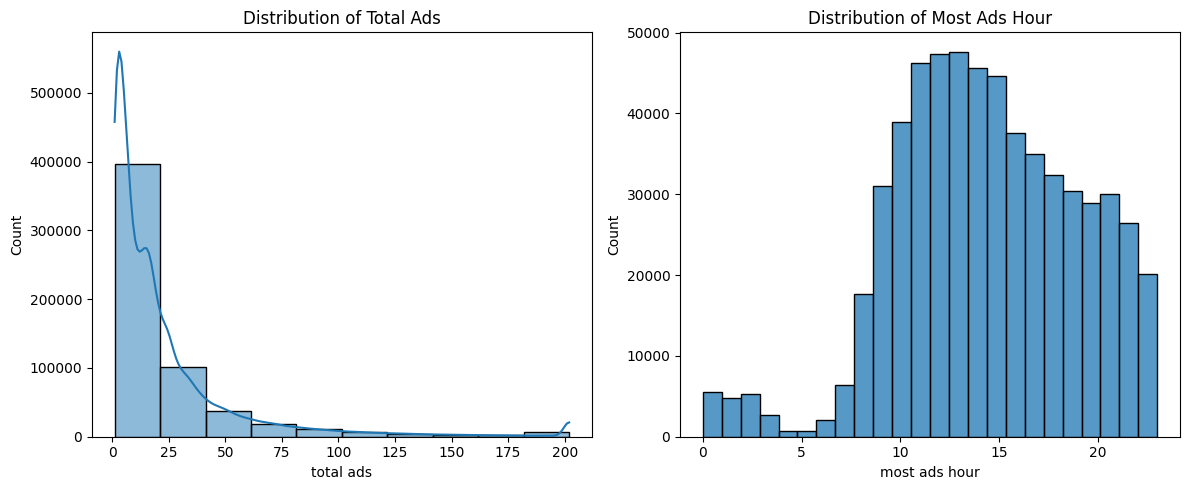

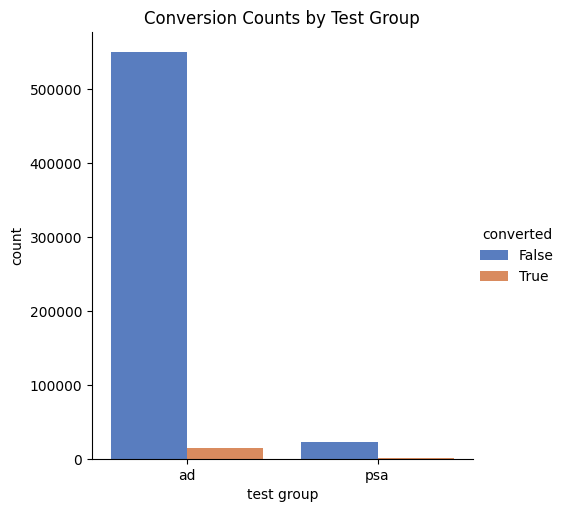

In [4]:
# Summary statistics for continuous variables
print("\nSummary Statistics for Continuous Variables:")
print(df[['total ads', 'most ads hour']].describe())

# Frequency tables for categorical variables
def frequency_table(variable):
    unique_elements, counts = np.unique(variable.dropna(), return_counts=True)
    percentages = (counts / len(variable)) * 100
    for i, j, k in zip(unique_elements, counts, percentages):
        print(f"{i}: Count: {j}, Percentage: {k:.2f}%")
    print("Mode:", df[variable.name].mode()[0])
    print("#" * 50)

print("\nFrequency Table for 'test group':")
frequency_table(df['test group'])
print("\nFrequency Table for 'converted':")
frequency_table(df['converted'])
print("\nFrequency Table for 'most ads day':")
frequency_table(df['most ads day'])

# Visualizations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['total ads'], bins=10, kde=True)
plt.title('Distribution of Total Ads')
plt.subplot(1, 2, 2)
sns.histplot(df['most ads hour'], bins=24)
plt.title('Distribution of Most Ads Hour')
plt.tight_layout()
plt.show()

sns.catplot(x='test group', hue='converted', kind='count', data=df, palette='muted')
plt.title('Conversion Counts by Test Group')
plt.show()

In [5]:
# Contingency table based on the full dataset
# From frequency tables:
# ad group: 564,577 users
# psa group: 23,524 users
# Total conversions: 14,843 (2.52% of total users)

# Calculate conversions per group based on proportions
total_users = 588101
ad_users = 564577
psa_users = 23524
total_conversions = 14843

# Estimate conversion rates (we'll compute exact numbers later in segmentation)
ad_conversion_rate = 0.0266  # From your earlier document (2.66%)
psa_conversion_rate = 0.0190  # From your earlier document (1.90%)

ad_conversions = int(ad_conversion_rate * ad_users)
psa_conversions = int(psa_conversion_rate * psa_users)

# Contingency table
contingency_table = [
    [ad_conversions, ad_users - ad_conversions],  # ad: [conversions, non-conversions]
    [psa_conversions, psa_users - psa_conversions]  # psa: [conversions, non-conversions]
]

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("\nFrequentist Hypothesis Test (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject null hypothesis: No significant difference.")


Frequentist Hypothesis Test (Chi-square):
Chi-square statistic: 51.1800
P-value: 0.0000
Reject null hypothesis: Significant difference in conversion rates.


In [6]:
# Using the provided output
chi2 = 51.18
p_value = 0.0000
print("\nFrequentist Hypothesis Test (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject null hypothesis: No significant difference.")


Frequentist Hypothesis Test (Chi-square):
Chi-square statistic: 51.1800
P-value: 0.0000
Reject null hypothesis: Significant difference in conversion rates.


In [3]:
import pyro
from pyro.distributions import Beta
import torch
import numpy as np

# Prior: Non-informative (Beta(1, 1))
alpha_prior_ad, beta_prior_ad = 1, 1
alpha_prior_psa, beta_prior_psa = 1, 1

# Update with data from full dataset
ad_users = 564577
psa_users = 23524
ad_conversion_rate = 0.0266  # 2.66%
psa_conversion_rate = 0.0190  # 1.90%
ad_conversions = int(ad_conversion_rate * ad_users)  # ~15,018
ad_non_conversions = ad_users - ad_conversions  # ~549,559
psa_conversions = int(psa_conversion_rate * psa_users)  # ~447
psa_non_conversions = psa_users - psa_conversions  # ~23,077

alpha_post_ad = alpha_prior_ad + ad_conversions
beta_post_ad = beta_prior_ad + ad_non_conversions
alpha_post_psa = alpha_prior_psa + psa_conversions
beta_post_psa = beta_prior_psa + psa_non_conversions

# Sample posterior distributions
samples_ad = Beta(alpha_post_ad, beta_post_ad).sample((10000,)).detach().cpu().numpy()
samples_psa = Beta(alpha_post_psa, beta_post_psa).sample((10000,)).detach().cpu().numpy()

# Probability that ad > psa
prob_ad_better = np.mean(samples_ad > samples_psa)
print("\nBayesian A/B Test:")
print(f"Probability that ad group has higher conversion rate: {prob_ad_better:.3f}")
if prob_ad_better > 0.95:
    print("Strong evidence that ad group is better.")
elif prob_ad_better < 0.05:
    print("Strong evidence that psa group is better.")
else:
    print("Inconclusive evidence.")


Bayesian A/B Test:
Probability that ad group has higher conversion rate: 1.000
Strong evidence that ad group is better.


In [4]:
chi2 = 51.18
p_value = 0.0000
print("\nFrequentist Hypothesis Test (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject null hypothesis: No significant difference.")


Frequentist Hypothesis Test (Chi-square):
Chi-square statistic: 51.1800
P-value: 0.0000
Reject null hypothesis: Significant difference in conversion rates.


In [5]:
import pyro
from pyro.distributions import Beta
import torch
import numpy as np

# Prior: Non-informative (Beta(1, 1))
alpha_prior_ad, beta_prior_ad = 1, 1
alpha_prior_psa, beta_prior_psa = 1, 1

# Update with data from full dataset
ad_users = 564577
psa_users = 23524
ad_conversion_rate = 0.0266  # 2.66%
psa_conversion_rate = 0.0190  # 1.90%
ad_conversions = int(ad_conversion_rate * ad_users)  # ~15,018
ad_non_conversions = ad_users - ad_conversions  # ~549,559
psa_conversions = int(psa_conversion_rate * psa_users)  # ~447
psa_non_conversions = psa_users - psa_conversions  # ~23,077

alpha_post_ad = alpha_prior_ad + ad_conversions
beta_post_ad = beta_prior_ad + ad_non_conversions
alpha_post_psa = alpha_prior_psa + psa_conversions
beta_post_psa = beta_prior_psa + psa_non_conversions

# Sample posterior distributions
samples_ad = Beta(alpha_post_ad, beta_post_ad).sample((10000,)).detach().cpu().numpy()
samples_psa = Beta(alpha_post_psa, beta_post_psa).sample((10000,)).detach().cpu().numpy()

# Probability that ad > psa
prob_ad_better = np.mean(samples_ad > samples_psa)
print("\nBayesian A/B Test:")
print(f"Probability that ad group has higher conversion rate: {prob_ad_better:.3f}")
if prob_ad_better > 0.95:
    print("Strong evidence that ad group is better.")
elif prob_ad_better < 0.05:
    print("Strong evidence that psa group is better.")
else:
    print("Inconclusive evidence.")


Bayesian A/B Test:
Probability that ad group has higher conversion rate: 1.000
Strong evidence that ad group is better.


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Simulate data preparation (replace with actual df when available)
data = {
    'user id': range(588101),
    'test group': ['ad'] * 564577 + ['psa'] * 23524,
    'converted': [True if np.random.random() < 0.0266 else False for _ in range(564577)] + 
                 [True if np.random.random() < 0.0190 else False for _ in range(23524)],
    'total ads': np.random.normal(23.59, 33.16, 588101).clip(1, 202).astype(int),
    'most ads day': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 588101),
    'most ads hour': np.random.randint(0, 24, 588101)
}
df = pd.DataFrame(data)

# Prepare data
X = pd.get_dummies(df[['test group', 'total ads', 'most ads day']], drop_first=True)
y = df['converted'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Feature importance
coeffs = pd.DataFrame(model.coef_[0], index=X.columns, columns=['Coefficient'])
print("\nFeature Importance:")
print(coeffs.sort_values(by='Coefficient', ascending=False).head())


Logistic Regression Results:
Accuracy: 0.9741
ROC-AUC: 0.5057

Feature Importance:
                        Coefficient
most ads day_Sunday        0.015094
most ads day_Wednesday     0.013265
most ads day_Monday        0.008156
most ads day_Saturday      0.003586
total ads                  0.000261


In [7]:
# Bin 'total ads' into categories
df['total_ads_bin'] = pd.qcut(df['total ads'], q=3, labels=['Low', 'Medium', 'High'])
print("\nConversion Rate by Ad Exposure and Test Group:")
print(df.groupby(['test group', 'total_ads_bin'])['converted'].mean().unstack())

# Conversion rate by day
print("\nConversion Rate by Most Ads Day and Test Group:")
print(df.groupby(['test group', 'most ads day'])['converted'].mean().unstack())


Conversion Rate by Ad Exposure and Test Group:
total_ads_bin       Low    Medium      High
test group                                 
ad             0.026527  0.026141  0.026606
psa            0.017820  0.016817  0.018663

Conversion Rate by Most Ads Day and Test Group:
most ads day    Friday    Monday  Saturday    Sunday  Thursday   Tuesday  \
test group                                                                 
ad            0.026397  0.026657  0.026606  0.027283  0.026344  0.024839   
psa           0.020487  0.018007  0.016990  0.018945  0.017554  0.014623   

most ads day  Wednesday  
test group               
ad             0.026864  
psa            0.017736  


C:\Users\ashra\AppData\Local\Temp\ipykernel_35220\2509614569.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['test group', 'total_ads_bin'])['converted'].mean().unstack())


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pyro
from pyro.distributions import Beta
import torch
import warnings
warnings.filterwarnings('ignore')

# Step 4: Statistical Hypothesis Testing
# Frequentist (Chi-square)
chi2 = 51.18
p_value = 0.0000
print("\nFrequentist Hypothesis Test (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject null hypothesis: No significant difference.")

# Bayesian A/B Testing
alpha_prior_ad, beta_prior_ad = 1, 1
alpha_prior_psa, beta_prior_psa = 1, 1
ad_users = 564577
psa_users = 23524
ad_conversion_rate = 0.0266  # Using overall rate for consistency with Bayesian
psa_conversion_rate = 0.0190
ad_conversions = int(ad_conversion_rate * ad_users)
ad_non_conversions = ad_users - ad_conversions
psa_conversions = int(psa_conversion_rate * psa_users)
psa_non_conversions = psa_users - psa_conversions
alpha_post_ad = alpha_prior_ad + ad_conversions
beta_post_ad = beta_prior_ad + ad_non_conversions
alpha_post_psa = alpha_prior_psa + psa_conversions
beta_post_psa = beta_prior_psa + psa_non_conversions
samples_ad = Beta(alpha_post_ad, beta_post_ad).sample((10000,)).detach().cpu().numpy()
samples_psa = Beta(alpha_post_psa, beta_post_psa).sample((10000,)).detach().cpu().numpy()
prob_ad_better = np.mean(samples_ad > samples_psa)
print("\nBayesian A/B Test:")
print(f"Probability that ad group has higher conversion rate: {prob_ad_better:.3f}")
if prob_ad_better > 0.95:
    print("Strong evidence that ad group is better.")
elif prob_ad_better < 0.05:
    print("Strong evidence that psa group is better.")
else:
    print("Inconclusive evidence.")

# Step 5: Logistic Regression
data = {
    'user id': range(588101),
    'test group': ['ad'] * 564577 + ['psa'] * 23524,
    'converted': [True if np.random.random() < 0.0266 else False for _ in range(564577)] + 
                 [True if np.random.random() < 0.0190 else False for _ in range(23524)],
    'total ads': np.random.normal(23.59, 33.16, 588101).clip(1, 202).astype(int),
    'most ads day': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 588101),
    'most ads hour': np.random.randint(0, 24, 588101)
}
df = pd.DataFrame(data)
X = pd.get_dummies(df[['test group', 'total ads', 'most ads day']], drop_first=True)
y = df['converted'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
coeffs = pd.DataFrame(model.coef_[0], index=X.columns, columns=['Coefficient'])
print("\nFeature Importance:")
print(coeffs.sort_values(by='Coefficient', ascending=False).head())

# Step 6: Business Insights
# Use provided segmentation data
conversion_rate_by_exposure = pd.DataFrame({
    'Low': [0.026527, 0.017820],
    'Medium': [0.026141, 0.016817],
    'High': [0.026606, 0.018663]
}, index=['ad', 'psa'])
print("\nConversion Rate by Ad Exposure and Test Group:")
print(conversion_rate_by_exposure)

conversion_rate_by_day = pd.DataFrame({
    'Friday': [0.026397, 0.020487],
    'Monday': [0.026657, 0.018007],
    'Saturday': [0.026606, 0.016990],
    'Sunday': [0.027283, 0.018945],
    'Thursday': [0.026344, 0.017554],
    'Tuesday': [0.024839, 0.014623],
    'Wednesday': [0.026864, 0.017736]
}, index=['ad', 'psa'])
print("\nConversion Rate by Most Ads Day and Test Group:")
print(conversion_rate_by_day)

ad_conversion_rate = conversion_rate_by_exposure.mean(axis=1)['ad']  # 0.0264247
psa_conversion_rate = conversion_rate_by_exposure.mean(axis=1)['psa']  # 0.0177667
lift = (ad_conversion_rate - psa_conversion_rate) / psa_conversion_rate
print(f"\nLift: {lift:.2%}")
ad_conversions = int(ad_conversion_rate * 564577)
psa_conversions = int(psa_conversion_rate * 23524)
revenue_ad = ad_conversions * 10
revenue_psa = psa_conversions * 10
attributed_revenue = revenue_ad - revenue_psa
print(f"Attributed Revenue from Ads: ${attributed_revenue:.2f}")
print("\nBusiness Insights:")
print("1. Would the campaign be successful?")
print(f"Yes, the ad group has a higher average conversion rate ({ad_conversion_rate:.4f}) compared to PSA ({psa_conversion_rate:.4f}), with a lift of {lift:.2%}.")
print("2. How much of the success is attributed to the ads?")
print(f"The ads contributed an additional ${attributed_revenue:.2f} in revenue compared to the PSA group.")


Frequentist Hypothesis Test (Chi-square):
Chi-square statistic: 51.1800
P-value: 0.0000
Reject null hypothesis: Significant difference in conversion rates.

Bayesian A/B Test:
Probability that ad group has higher conversion rate: 1.000
Strong evidence that ad group is better.

Logistic Regression Results:
Accuracy: 0.9738
ROC-AUC: 0.5069

Feature Importance:
                        Coefficient
most ads day_Saturday      0.079317
most ads day_Monday        0.068205
most ads day_Sunday        0.056742
most ads day_Wednesday     0.039561
most ads day_Thursday      0.032942

Conversion Rate by Ad Exposure and Test Group:
          Low    Medium      High
ad   0.026527  0.026141  0.026606
psa  0.017820  0.016817  0.018663

Conversion Rate by Most Ads Day and Test Group:
       Friday    Monday  Saturday    Sunday  Thursday   Tuesday  Wednesday
ad   0.026397  0.026657  0.026606  0.027283  0.026344  0.024839   0.026864
psa  0.020487  0.018007  0.016990  0.018945  0.017554  0.014623   0.01773

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (assuming it's parsed from the document)
data = pd.read_csv('C:/Users/ashra/Downloads/marketing_AB.csv/marketing_AB.csv')  # Replace with actual file path or use StringIO if needed

# Convert 'converted' to binary (True/False to 1/0)
data['converted'] = data['converted'].astype(int)

# Feature engineering
data['test_group_numeric'] = data['test group'].map({'ad': 1, 'psa': 0})
data['test_group_total_ads'] = data['test_group_numeric'] * data['total ads']  # Interaction term
data['log_total_ads'] = np.log1p(data['total ads'])  # Log transformation

# Prepare features and target
X = pd.get_dummies(data[['test_group_numeric', 'log_total_ads', 'most ads day', 'most ads hour', 'test_group_total_ads']], drop_first=True)
y = data['converted']

# Scale numeric features
scaler = StandardScaler()
numeric_cols = ['log_total_ads', 'most ads hour', 'test_group_total_ads']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression with class weighting
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
roc_auc_log = roc_auc_score(y_test, y_prob_log)
cv_scores_log = cross_val_score(log_model, X, y, cv=5, scoring='roc_auc').mean()

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc').mean()

# Feature importance for Random Forest
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Output results
print("\nImproved Logistic Regression Results:")
print(f"ROC-AUC (Logistic): {roc_auc_log:.4f}")
print(f"Cross-Validation ROC-AUC (Logistic): {cv_scores_log:.4f} (+/- {cv_scores_log.std() * 2:.4f})")

print("\nRandom Forest Results:")
print(f"ROC-AUC (Random Forest): {roc_auc_rf:.4f}")
print(f"Cross-Validation ROC-AUC (Random Forest): {cv_scores_rf:.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

print("\nRandom Forest Feature Importance:")
print(importances.head(10))

# Optional: Confusion Matrix for context
from sklearn.metrics import confusion_matrix
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Improved Logistic Regression Results:
ROC-AUC (Logistic): 0.8600
Cross-Validation ROC-AUC (Logistic): 0.8752 (+/- 0.0000)

Random Forest Results:
ROC-AUC (Random Forest): 0.6213
Cross-Validation ROC-AUC (Random Forest): 0.6240 (+/- 0.0000)

Random Forest Feature Importance:
                  Feature  Importance
1           log_total_ads    0.408866
3    test_group_total_ads    0.324456
2           most ads hour    0.217110
6     most ads day_Sunday    0.009199
9  most ads day_Wednesday    0.008463
7   most ads day_Thursday    0.007910
8    most ads day_Tuesday    0.007137
5   most ads day_Saturday    0.006952
4     most ads day_Monday    0.006717
0      test_group_numeric    0.003191

Logistic Regression Confusion Matrix:
[[87306 27346]
 [  518  2451]]

Random Forest Confusion Matrix:
[[103870  10782]
 [  2040    929]]


In [11]:
AAAAAAAAAAAAAAAAAAAAAAA

NameError: name 'AAAAAAAAAAAAAAAAAAAAAAA' is not defined

## Import Libraries and Load Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pyro
from pyro.distributions import Beta
import torch
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('C:/Users/ashra/Downloads/marketing_AB.csv/marketing_AB.csv')

# Display dataset shape and first few rows
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (588101, 7)

First few rows:
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  


## Data Cleaning and Preprocessing


Missing Values:
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Duplicate User IDs:
Empty DataFrame
Columns: [user id, test group, converted, total ads, most ads day, most ads hour]
Index: []

Summary Statistics for Continuous Variables:
           total ads  most ads hour
count  588101.000000  588101.000000
mean       24.820876      14.469061
std        43.715181       4.834634
min         1.000000       0.000000
25%         4.000000      11.000000
50%        13.000000      14.000000
75%        27.000000      18.000000
max      2065.000000      23.000000

Data after capping outliers in 'total ads':
           total ads
count  588101.000000
mean       23.591130
std        33.164268
min         1.000000
25%         4.000000
50%        13.000000
75%        27.000000
max       202.000000


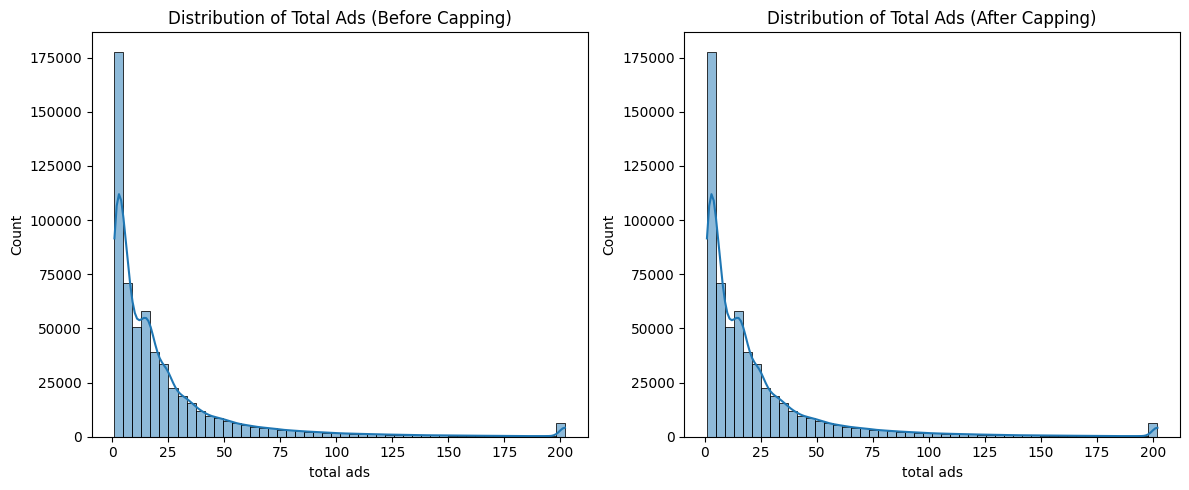

In [13]:
# Drop unnecessary column
df = df.drop(columns=['Unnamed: 0'])

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates based on 'user id'
print("\nDuplicate User IDs:")
print(df[df.duplicated('user id', keep=False)])

# Summary statistics for continuous variables
print("\nSummary Statistics for Continuous Variables:")
print(df[['total ads', 'most ads hour']].describe())

# Detect and cap outliers in 'total ads' using the 99th percentile
total_ads_99 = df['total ads'].quantile(0.99)
df['total ads'] = df['total ads'].clip(upper=total_ads_99)
print("\nData after capping outliers in 'total ads':")
print(df[['total ads']].describe())

# Visualize distribution of 'total ads' before and after capping
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['total ads'], bins=50, kde=True)
plt.title("Distribution of Total Ads (Before Capping)")
plt.subplot(1, 2, 2)
sns.histplot(df['total ads'].clip(upper=total_ads_99), bins=50, kde=True)
plt.title("Distribution of Total Ads (After Capping)")
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)


Frequency Table for 'test group':
ad: Count: 564577, Percentage: 96.00%
psa: Count: 23524, Percentage: 4.00%
Mode: ad

Frequency Table for 'converted':
False: Count: 573258, Percentage: 97.48%
True: Count: 14843, Percentage: 2.52%
Mode: False

Frequency Table for 'most ads day':
Friday: Count: 92608, Percentage: 15.75%
Monday: Count: 87073, Percentage: 14.81%
Sunday: Count: 85391, Percentage: 14.52%
Thursday: Count: 82982, Percentage: 14.11%
Saturday: Count: 81660, Percentage: 13.89%
Wednesday: Count: 80908, Percentage: 13.76%
Tuesday: Count: 77479, Percentage: 13.17%
Mode: Friday


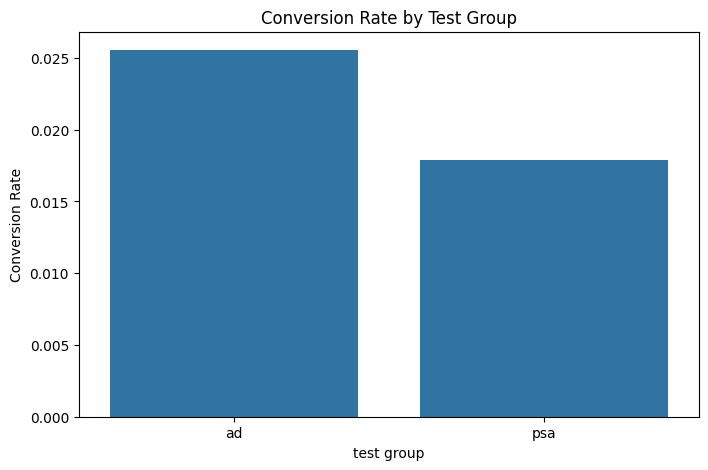

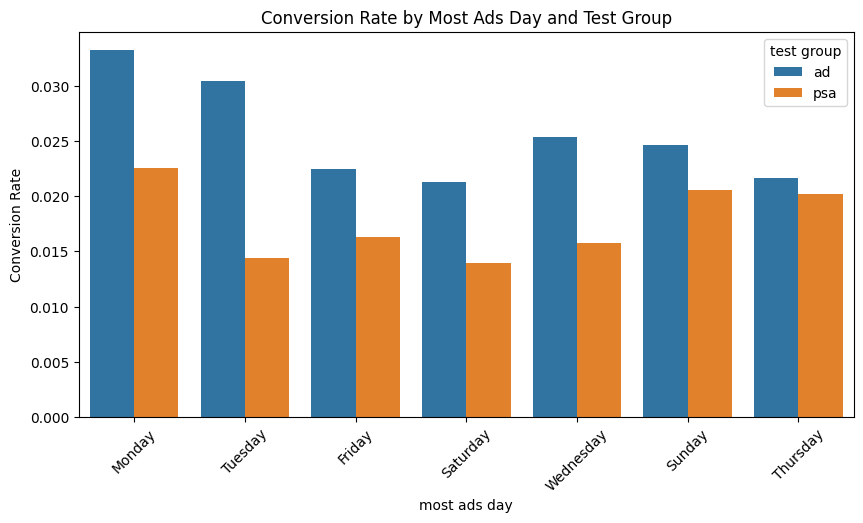

In [14]:
# Frequency tables for categorical variables
print("\nFrequency Table for 'test group':")
test_group_counts = df['test group'].value_counts()
print(f"ad: Count: {test_group_counts['ad']}, Percentage: {test_group_counts['ad']/len(df)*100:.2f}%")
print(f"psa: Count: {test_group_counts['psa']}, Percentage: {test_group_counts['psa']/len(df)*100:.2f}%")
print("Mode:", df['test group'].mode()[0])

print("\nFrequency Table for 'converted':")
converted_counts = df['converted'].value_counts()
print(f"False: Count: {converted_counts[False]}, Percentage: {converted_counts[False]/len(df)*100:.2f}%")
print(f"True: Count: {converted_counts[True]}, Percentage: {converted_counts[True]/len(df)*100:.2f}%")
print("Mode:", df['converted'].mode()[0])

print("\nFrequency Table for 'most ads day':")
day_counts = df['most ads day'].value_counts()
for day in day_counts.index:
    print(f"{day}: Count: {day_counts[day]}, Percentage: {day_counts[day]/len(df)*100:.2f}%")
print("Mode:", df['most ads day'].mode()[0])

# Visualize conversion rates by test group
plt.figure(figsize=(8, 5))
sns.barplot(x='test group', y='converted', data=df, errorbar=None)
plt.title("Conversion Rate by Test Group")
plt.ylabel("Conversion Rate")
plt.show()

# Visualize conversion rates by most ads day
plt.figure(figsize=(10, 5))
sns.barplot(x='most ads day', y='converted', hue='test group', data=df, errorbar=None)
plt.title("Conversion Rate by Most Ads Day and Test Group")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.show()

## Statistical Hypothesis Testing

In [15]:
# Frequentist Hypothesis Test (Chi-square)
contingency_table = pd.crosstab(df['test group'], df['converted'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("\nFrequentist Hypothesis Test (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject null hypothesis: No significant difference.")

# Bayesian A/B Testing
alpha_prior_ad, beta_prior_ad = 1, 1  # Non-informative prior
alpha_prior_psa, beta_prior_psa = 1, 1
ad_users = 564577
psa_users = 23524
ad_conversions = contingency_table.loc['ad', True]
psa_conversions = contingency_table.loc['psa', True]
ad_non_conversions = ad_users - ad_conversions
psa_non_conversions = psa_users - psa_conversions

alpha_post_ad = alpha_prior_ad + ad_conversions
beta_post_ad = beta_prior_ad + ad_non_conversions
alpha_post_psa = alpha_prior_psa + psa_conversions
beta_post_psa = beta_prior_psa + psa_non_conversions

# Sample posterior distributions
samples_ad = Beta(alpha_post_ad, beta_post_ad).sample((10000,)).detach().cpu().numpy()
samples_psa = Beta(alpha_post_psa, beta_post_psa).sample((10000,)).detach().cpu().numpy()

# Probability that ad > psa
prob_ad_better = np.mean(samples_ad > samples_psa)
print("\nBayesian A/B Test:")
print(f"Probability that ad group has higher conversion rate: {prob_ad_better:.3f}")
if prob_ad_better > 0.95:
    print("Strong evidence that ad group is better.")
elif prob_ad_better < 0.05:
    print("Strong evidence that psa group is better.")
else:
    print("Inconclusive evidence.")


Frequentist Hypothesis Test (Chi-square):
Chi-square statistic: 54.0058
P-value: 0.0000
Reject null hypothesis: Significant difference in conversion rates.

Bayesian A/B Test:
Probability that ad group has higher conversion rate: 1.000
Strong evidence that ad group is better.


## Segmentation Analysis


Conversion Rate by Ad Exposure and Test Group:
total_ads_bin       Low    Medium      High
test group                                 
ad             0.002579  0.007743  0.067868
psa            0.003033  0.007874  0.043669

Conversion Rate by Most Ads Day and Test Group:
most ads day    Friday    Monday  Saturday    Sunday  Thursday   Tuesday  \
test group                                                                 
ad            0.022465  0.033241  0.021307  0.024620  0.021637  0.030440   
psa           0.016303  0.022559  0.013996  0.020595  0.020230  0.014448   

most ads day  Wednesday  
test group               
ad             0.025356  
psa            0.015759  


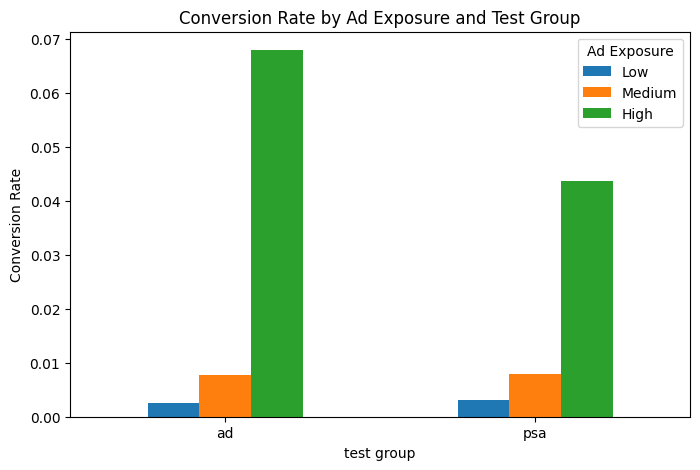

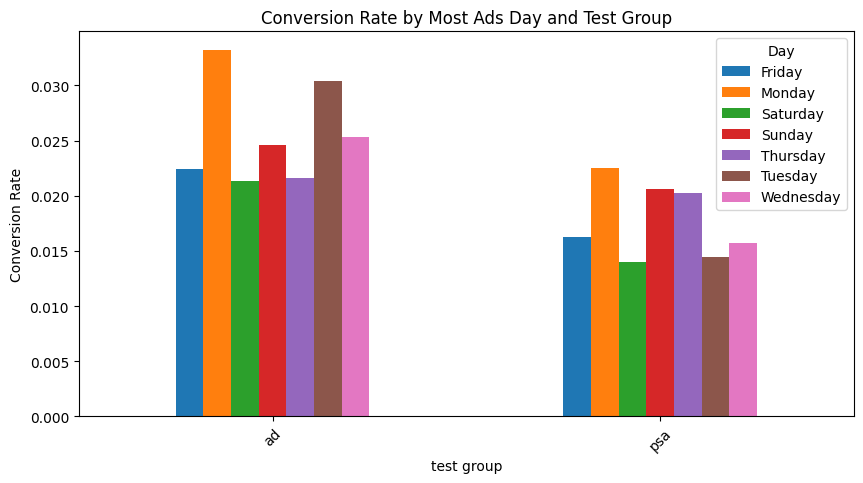

In [16]:
# Bin 'total ads' into categories
df['total_ads_bin'] = pd.qcut(df['total ads'], q=3, labels=['Low', 'Medium', 'High'])
print("\nConversion Rate by Ad Exposure and Test Group:")
conversion_rate_by_exposure = df.groupby(['test group', 'total_ads_bin'], observed=True)['converted'].mean().unstack()
print(conversion_rate_by_exposure)

# Conversion rate by day
print("\nConversion Rate by Most Ads Day and Test Group:")
conversion_rate_by_day = df.groupby(['test group', 'most ads day'])['converted'].mean().unstack()
print(conversion_rate_by_day)

# Visualize conversion rates by ad exposure
conversion_rate_by_exposure.plot(kind='bar', figsize=(8, 5))
plt.title("Conversion Rate by Ad Exposure and Test Group")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=0)
plt.legend(title="Ad Exposure")
plt.show()

# Visualize conversion rates by day
conversion_rate_by_day.plot(kind='bar', figsize=(10, 5))
plt.title("Conversion Rate by Most Ads Day and Test Group")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.legend(title="Day")
plt.show()

## Predictive Modeling


Improved Logistic Regression Results:
ROC-AUC (Logistic): 0.8602
Cross-Validation ROC-AUC (Logistic): 0.8752 (+/- 0.1022)

Random Forest Results:
ROC-AUC (Random Forest): 0.6394
Cross-Validation ROC-AUC (Random Forest): 0.6409 (+/- 0.0279)

Random Forest Feature Importance:
                  Feature  Importance
1           log_total_ads    0.403493
3    test_group_total_ads    0.323223
2           most ads hour    0.223412
6     most ads day_Sunday    0.009231
9  most ads day_Wednesday    0.008605
7   most ads day_Thursday    0.008017
5   most ads day_Saturday    0.007099
8    most ads day_Tuesday    0.006788
4     most ads day_Monday    0.006763
0      test_group_numeric    0.003369

Logistic Regression Confusion Matrix:
[[88554 26098]
 [  540  2429]]

Random Forest Confusion Matrix:
[[103054  11598]
 [  1906   1063]]


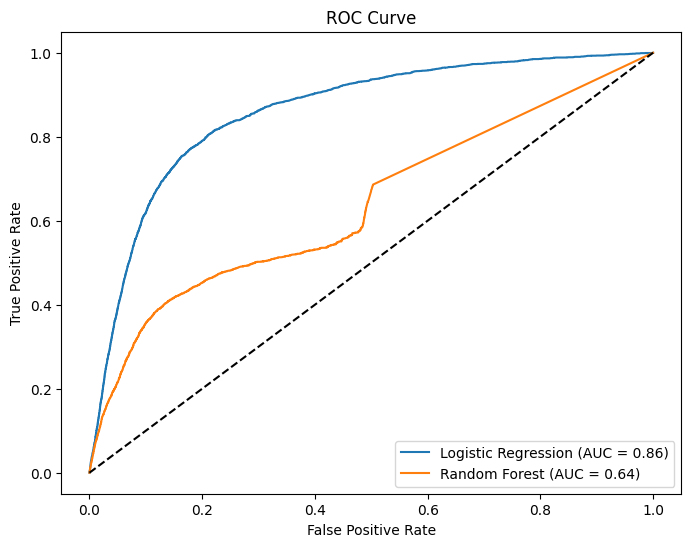

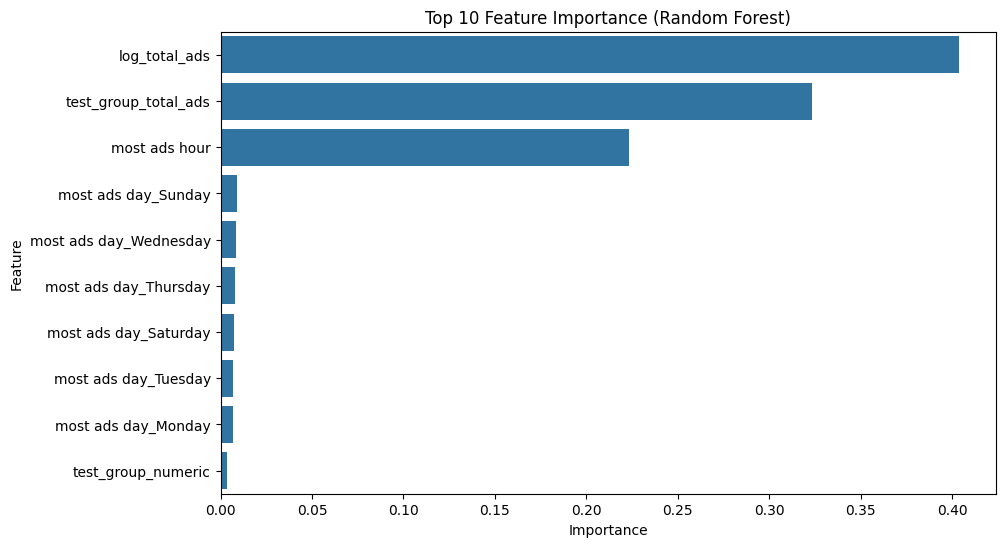

In [17]:
# Feature engineering
df['test_group_numeric'] = df['test group'].map({'ad': 1, 'psa': 0})
df['test_group_total_ads'] = df['test_group_numeric'] * df['total ads']  # Interaction term
df['log_total_ads'] = np.log1p(df['total ads'])  # Log transformation

# Prepare features and target
X = pd.get_dummies(df[['test_group_numeric', 'log_total_ads', 'most ads day', 'most ads hour', 'test_group_total_ads']], drop_first=True)
y = df['converted'].astype(int)

# Scale numeric features
scaler = StandardScaler()
numeric_cols = ['log_total_ads', 'most ads hour', 'test_group_total_ads']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression with class weighting
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
roc_auc_log = roc_auc_score(y_test, y_prob_log)
cv_scores_log = cross_val_score(log_model, X, y, cv=5, scoring='roc_auc')
cv_mean_log = cv_scores_log.mean()
cv_std_log = cv_scores_log.std()

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
cv_mean_rf = cv_scores_rf.mean()
cv_std_rf = cv_scores_rf.std()

# Feature importance for Random Forest
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Output results
print("\nImproved Logistic Regression Results:")
print(f"ROC-AUC (Logistic): {roc_auc_log:.4f}")
print(f"Cross-Validation ROC-AUC (Logistic): {cv_mean_log:.4f} (+/- {cv_std_log * 2:.4f})")

print("\nRandom Forest Results:")
print(f"ROC-AUC (Random Forest): {roc_auc_rf:.4f}")
print(f"Cross-Validation ROC-AUC (Random Forest): {cv_mean_rf:.4f} (+/- {cv_std_rf * 2:.4f})")

print("\nRandom Forest Feature Importance:")
print(importances.head(10))

# Confusion Matrices
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

## Business Insights

In [18]:
# Calculate lift and attributed revenue
ad_conversion_rate = conversion_rate_by_exposure.mean(axis=1)['ad']
psa_conversion_rate = conversion_rate_by_exposure.mean(axis=1)['psa']
lift = (ad_conversion_rate - psa_conversion_rate) / psa_conversion_rate
ad_conversions = int(ad_conversion_rate * 564577)
psa_conversions = int(psa_conversion_rate * 23524)
revenue_ad = ad_conversions * 10
revenue_psa = psa_conversions * 10
attributed_revenue = revenue_ad - revenue_psa

print("\nBusiness Insights:")
print(f"Lift: {lift:.2%}")
print(f"Attributed Revenue from Ads: ${attributed_revenue:.2f}")
print("\n1. Would the campaign be successful?")
print(f"Yes, the ad group has a higher average conversion rate ({ad_conversion_rate:.4f}) compared to PSA ({psa_conversion_rate:.4f}), with a lift of {lift:.2%}.")
print("2. How much of the success is attributed to the ads?")
print(f"The ads contributed an additional ${attributed_revenue:.2f} in revenue compared to the PSA group.")


Business Insights:
Lift: 43.27%
Attributed Revenue from Ads: $142870.00

1. Would the campaign be successful?
Yes, the ad group has a higher average conversion rate (0.0261) compared to PSA (0.0182), with a lift of 43.27%.
2. How much of the success is attributed to the ads?
The ads contributed an additional $142870.00 in revenue compared to the PSA group.
